In [2]:
#importing the MNIST dataset to understand classification models
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version =1)
mnist.keys()

C:\Users\vishw\anaconda3\Lib\site-packages\sklearn\datasets\_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X,y = mnist['data'], mnist['target']
print(X.shape, y.shape)

(70000, 784) (70000,)


Each row contains intensity of an 28*28 = 784 pixels which can be used to depict images of handwritten digits form 0 to 9

In [7]:
y.value_counts() 

class
1    7877
7    7293
3    7141
2    6990
9    6958
0    6903
6    6876
8    6825
4    6824
5    6313
Name: count, dtype: int64

In [32]:
y=y.astype('int')

The data can be interpreted as homogenous 

In [33]:
#let us split the dataset into train and test set before any further analysis. This dataset available at sklearn is already divided into stratified samples for training and testing with shuffling of index.
X_train, X_test, y_train, y_test = X[:60000],X[60000:],y[:60000],y[:60000]


In [34]:
#let's start by training a binary classifier on the dataset
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [35]:
#We will use a Stochastics gradient descent classifier since it is fast
from sklearn.linear_model import SGDClassifier
sgd_classifier = SGDClassifier()
sgd_classifier.fit(X_train, y_train_5)


SGDClassifier()

In [36]:
#let us measure the accuracy of this model using cross-validation
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_classifier, X_train, y_train_5, cv=5,scoring='accuracy' )

array([0.95375   , 0.96891667, 0.96033333, 0.95366667, 0.96708333])

Our model is providing a pretty much good accuray across all the 5 samples. But we will find out that accuracy does'nt depict the real performance of our classifier since there is huge class imbalance in target column y_train_5.

In [47]:
#let's create a function to calculate cross_validation score such that each sample taken is stratified, therefore representing the dataset in a better way.
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

def cross_validate_accuracy(model, cv, X,y):
    skf = StratifiedKFold(n_splits =cv)
    accuracy = []
    for train_index, test_index in skf.split(X,y):
        model = clone(model) #to create a clone of the model, forgetting every parameter it has learned except the hyperparameter specified.
        X_train_fold = X.iloc[train_index] #will return one training fold each time the loop is executed using the stratified train index
        y_train_fold =y.iloc[train_index]
        X_test_fold = X.iloc[test_index]
        y_test_fold = y.iloc[test_index]
        model.fit(X_train_fold, y_train_fold)
        predicted = model.predict(X_test_fold)
        acc = sum(y_test_fold == predicted)/len(y_test_fold)
        accuracy.append(acc)
    return accuracy

In [48]:
print(cross_validate_accuracy(sgd_classifier, 5, X_train, y_train_5))

[0.9623333333333334, 0.9655, 0.9593333333333334, 0.9668333333333333, 0.9561666666666667]


We can observe that the accuracy is great, but maybe we are not able to see the full picture here. We will use confusion matrix to observe the full picture of our classification problem.

In [59]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_classifier, X_train, y_train_5, cv=3)

In [61]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_train_5, y_train_pred)
cm

array([[53734,   845],
       [ 1615,  3806]], dtype=int64)

In [62]:
#let us assign these four numbers to their respective variables with a correct representation.
true_negative = cm[0][0]
false_positive = cm[0][1]
false_negative = cm[1][0]
true_positive = cm[1][1]
precision = true_positive/(true_positive+false_positive) #how many of predicted positives are actually positives
recall = true_positive/(true_positive+false_negative) #out of all actual positives how many was our predictor able to classify correct
#recall is also called sensitivity or true positive rate
#let us calculate precision and recall
print('precision',precision,'recall',recall)

precision 0.8183186411524404 recall 0.7020844862571481


In [64]:
#let us see how we can use sklearn to calculate these metrics
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_pred=y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.8183186411524404
0.7020844862571481


We can observe that the scores calculated by sklearn are similar.

In [66]:
#it is often convenient to take the harmonic mean of precision score and recall score to get an average idea of overall performance of the model.
f1_score=((2*precision*recall)/(precision+recall))
print(f1_score)

0.755758538522637


We need to understand that there is a tradeoff between precision and recall 
#### Increasing precision decreases recall
In the above case we got the final prediction but we can also get the scores if we use the `decision_function()` method of SGDClassifier. Now we will use the scores and manipulate the threshold to get an understanding of the tradeoff between precision and recall.

In [67]:
#the default threshold for SGDClassifier is zero
y_train_scores = cross_val_predict(sgd_classifier, X_train, y_train_5, cv=3, method='decision_function')
import matplotlib.pyplot as plt
#Now with these scores we can compute precision, recall for all thresholds using the sklearn function
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_train_scores)

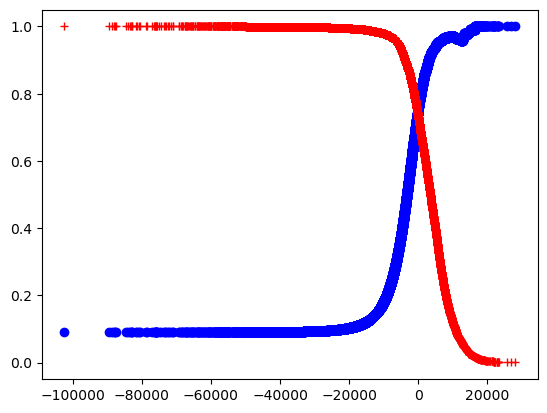

In [72]:
plt.plot(thresholds, precisions[:-1], 'bo', label='precision')
plt.plot(thresholds, recalls[:-1], 'r+', label = 'recall')
plt.show()